<a href="https://colab.research.google.com/github/marymiti/Data_Projects/blob/main/Refined_Hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive'


 0911.MP3
 20220715_5103383_DataAnalyst_Akpowowo_O_CV.pdf
'2372675 Assessment (7CS039 - Statistics for AI & Data Science) (1).docx'
'2372675 Assessment (7CS039 - Statistics for AI & Data Science).docx'
 2372675+-+Data+Visualization+Assessment+%287CS035%29_-29485388.gdoc
'4. Bank Details.doc'
'About Data.gslides'
'AI Assessment Draft.gdoc'
 all_model_cv_results_10fold.csv
 all_model_results.csv
 all_model_results_detailed.csv
 all_model_results_lexicon.csv
 all_model_summary_results.csv
'AltSchool Data Analysis Assignment 1 (1)'
'AltSchool Data Analysis Assignment 1 (File responses)'
'AltSchool Data Analysis Assignment 1.gform'
'AltSchool Data Analysis Assignment 1 (Responses).gsheet'
'AltSchool Data Analysis - MONTH 2 WEEK 3.gslides'
'AltSchool Data Analysis - MONTH 2 WEEK 5.gslides'
'AltSchool Data Analysis - MONTH 3 WEEK 2.gslides'
'AltSchool Data Analysis - MONTH 3 WEEK 4.gslides'
'AltSchool Data Analysis - Second Semester.gslides'
'AltSchool - Power BI.gslides'
'Alt School spreadsh

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Custom path for nltk data
custom_nltk_path = "/content/nltk_data"
nltk.data.path.append(custom_nltk_path)

# Download necessary resources
nltk.download('punkt', download_dir=custom_nltk_path, quiet=False)
nltk.download('stopwords', download_dir=custom_nltk_path, quiet=False)
nltk.download('wordnet', download_dir=custom_nltk_path, quiet=False)
nltk.download('omw-1.4', download_dir=custom_nltk_path, quiet=False)

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    stop_words = set(stopwords.words("english"))  # Load stopwords
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()  # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Load dataset
file_path = "/content/drive/My Drive/dataset.csv"
df = pd.read_csv(file_path)

# Ensure text column is clean and convert to string
df["text"] = df["text"].astype(str)

# Remove duplicates and null values
df = df.drop_duplicates()
df = df.dropna(subset=["text", "sentiment"])

# Apply preprocessing
df["text"] = df["text"].apply(preprocess_text)

# Map sentiment to numerical labels
df["label"] = df["sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})
df = df[["text", "label"]]

# Save processed dataset
processed_file_path = "/content/drive/My Drive/processed_full_dataset.csv"
df.to_csv(processed_file_path, index=False)
print(f"Processed dataset saved to: {processed_file_path}")

# Check dataset size and class distribution
print(f"Number of records: {len(df)}")
print("Class distribution:")
print(df["label"].value_counts())


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data] Downloading package omw-1.4 to /content/nltk_data...


Processed dataset saved to: /content/drive/My Drive/processed_full_dataset.csv
Number of records: 32420
Class distribution:
label
2    10842
0    10825
1    10753
Name: count, dtype: int64


In [ ]:
# Split data into training and testing sets (80/20 split)
split_idx = int(len(df) * 0.8)
train_texts, train_labels = df["text"][:split_idx].tolist(), df["label"][:split_idx].tolist()
test_texts, test_labels = df["text"][split_idx:].tolist(), df["label"][split_idx:].tolist()

# Verify the split
print(f"Training set size: {len(train_texts)}, Testing set size: {len(test_texts)}")


Training set size: 25936, Testing set size: 6484


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support
import time

# Define Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Define Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, llm_name, hidden_dim, num_classes):
        super(HybridModel, self).__init__()
        self.llm = AutoModel.from_pretrained(llm_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            llm_outputs = self.llm(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = llm_outputs.last_hidden_state
        lstm_out, (hidden, _) = self.lstm(embeddings)
        pooled_output = hidden[-1]
        dropped_output = self.dropout(pooled_output)
        logits = self.fc(dropped_output)
        return logits


In [ ]:
# Initialize tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel("yiyanghkust/finbert-tone", hidden_dim=256, num_classes=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
# Training loop
epochs = 10
results = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0
    start_time = time.time()

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    training_time = time.time() - start_time
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=1)
    inference_time = time.time() - start_time - training_time

    results.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "training_time": training_time,
        "inference_time": inference_time,
    })

# Save results
results_df = pd.DataFrame(results)
results_file_path = "/content/full_hybrid_model_results.csv"
results_df.to_csv(results_file_path, index=False)
print(f"Results saved to: {results_file_path}")


Epoch 1/10
Epoch 1 - Train Loss: 0.9916, Train Accuracy: 0.5150
Epoch 2/10
Epoch 2 - Train Loss: 0.9240, Train Accuracy: 0.5603
Epoch 3/10
Epoch 3 - Train Loss: 0.8980, Train Accuracy: 0.5775
Epoch 4/10
Epoch 4 - Train Loss: 0.8776, Train Accuracy: 0.5899
Epoch 5/10
Epoch 5 - Train Loss: 0.8620, Train Accuracy: 0.5975
Epoch 6/10
Epoch 6 - Train Loss: 0.8480, Train Accuracy: 0.6090
Epoch 7/10
Epoch 7 - Train Loss: 0.8340, Train Accuracy: 0.6143
Epoch 8/10
Epoch 8 - Train Loss: 0.8207, Train Accuracy: 0.6243
Epoch 9/10
Epoch 9 - Train Loss: 0.8078, Train Accuracy: 0.6283
Epoch 10/10
Epoch 10 - Train Loss: 0.7960, Train Accuracy: 0.6366
Results saved to: /content/full_hybrid_model_results.csv


In [ ]:
# Initialize tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Updated model initialization with new hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel("yiyanghkust/finbert-tone", hidden_dim=256, num_classes=3).to(device)

# Adjusted optimizer with lower learning rate and increased weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Regularization: Adding attention layer and increasing dropout will be handled in the model definition.


In [ ]:
# Training loop with updated hyperparameters
epochs = 10
results = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0
    start_time = time.time()

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    training_time = time.time() - start_time
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=1)
    inference_time = time.time() - start_time - training_time

    results.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "training_time": training_time,
        "inference_time": inference_time,
    })

    # Save model checkpoint
    checkpoint_path = f"/content/drive/My Drive/hybrid_model_new_params_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")


Epoch 1/10
Epoch 1 - Train Loss: 1.0172, Train Accuracy: 0.4968
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_1.pth
Epoch 2/10
Epoch 2 - Train Loss: 0.9523, Train Accuracy: 0.5460
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_2.pth
Epoch 3/10
Epoch 3 - Train Loss: 0.9293, Train Accuracy: 0.5620
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_3.pth
Epoch 4/10
Epoch 4 - Train Loss: 0.9154, Train Accuracy: 0.5687
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_4.pth
Epoch 5/10
Epoch 5 - Train Loss: 0.8997, Train Accuracy: 0.5786
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_5.pth
Epoch 6/10
Epoch 6 - Train Loss: 0.8889, Train Accuracy: 0.5815
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_6.pth
Epoch 7/10
Epoch 7 - Train Loss: 0.8780, Train Accuracy: 0.5888
Checkpoint saved: /content/drive/My Drive/hybrid_model_new_params_epoch_7.pth
Epoch 

Results saved to: /content/drive/My Drive/hybrid_model_results_new_params.csv


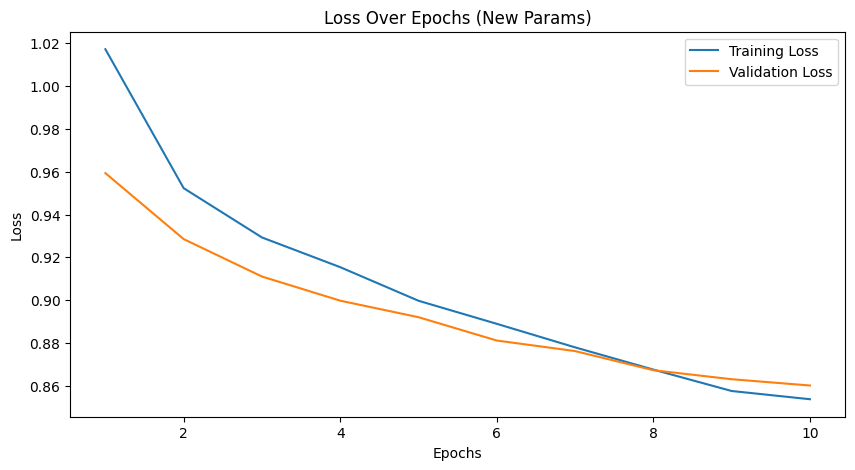

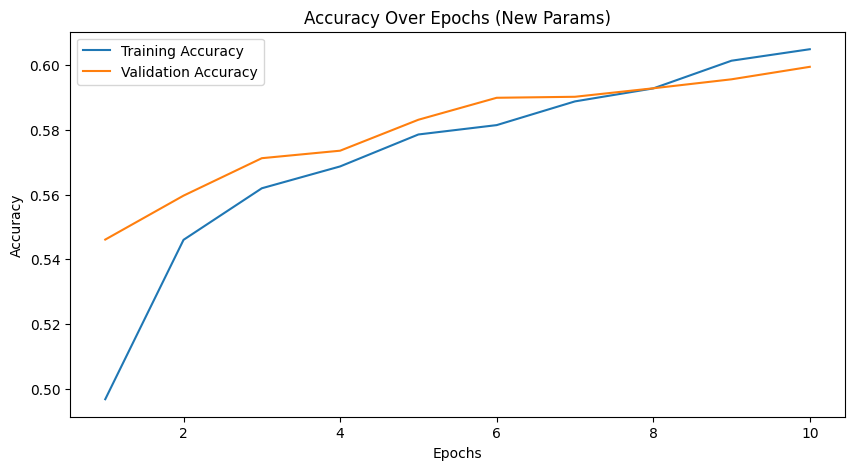

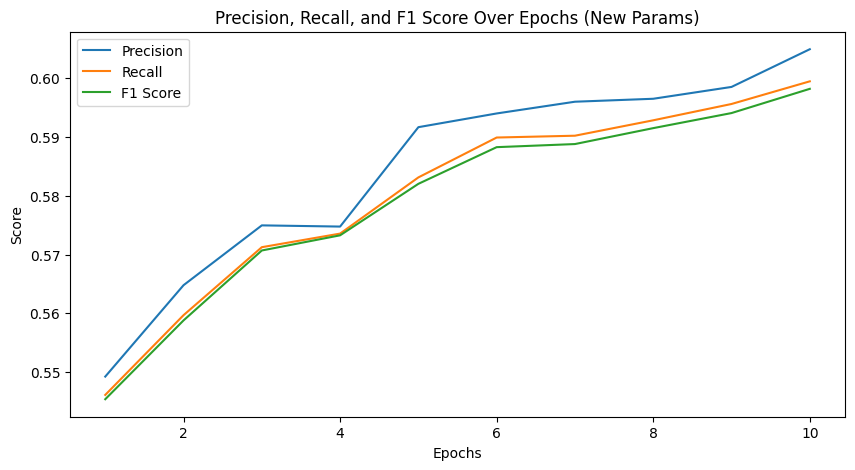

In [ ]:
# Save results to a new file for this hyperparameter set
results_df = pd.DataFrame(results)
results_file_path = "/content/drive/My Drive/hybrid_model_results_new_params.csv"
results_df.to_csv(results_file_path, index=False)
print(f"Results saved to: {results_file_path}")

# Plotting the updated training and validation metrics
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(results_df["epoch"], results_df["train_loss"], label="Training Loss")
plt.plot(results_df["epoch"], results_df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs (New Params)")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(results_df["epoch"], results_df["train_accuracy"], label="Training Accuracy")
plt.plot(results_df["epoch"], results_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs (New Params)")
plt.legend()
plt.show()

# Plot Precision, Recall, and F1
plt.figure(figsize=(10, 5))
plt.plot(results_df["epoch"], results_df["precision"], label="Precision")
plt.plot(results_df["epoch"], results_df["recall"], label="Recall")
plt.plot(results_df["epoch"], results_df["f1"], label="F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score Over Epochs (New Params)")
plt.legend()
plt.show()


In [ ]:
# Preprocessing (ensure you run this after loading your dataset)
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Load dataset
file_path = "/content/drive/My Drive/dataset.csv"
df = pd.read_csv(file_path)

# Preprocess text column
df["text"] = df["text"].astype(str).apply(preprocess_text)

# Remove duplicates and null values
df = df.drop_duplicates()
df = df.dropna(subset=["text", "sentiment"])

# Map sentiment to numerical labels
df["label"] = df["sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})

# Split dataset into training and testing
split_idx = int(len(df) * 0.8)
train_texts, train_labels = df["text"][:split_idx].tolist(), df["label"][:split_idx].tolist()
test_texts, test_labels = df["text"][split_idx:].tolist(), df["label"][split_idx:].tolist()

print(f"Dataset size: {len(df)} (Train: {len(train_texts)}, Test: {len(test_texts)})")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Dataset size: 32174 (Train: 25739, Test: 6435)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support
import time

# Define Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Define Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, llm_name, hidden_dim, num_classes):
        super(HybridModel, self).__init__()
        self.llm = AutoModel.from_pretrained(llm_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            llm_outputs = self.llm(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = llm_outputs.last_hidden_state
        lstm_out, _ = self.lstm(embeddings)
        pooled_out = lstm_out.mean(dim=1)
        dropped_out = self.dropout(pooled_out)
        logits = self.fc(dropped_out)
        return logits

# Initialize Tokenizer, Dataset, and DataLoader
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length=128)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel("yiyanghkust/finbert-tone", hidden_dim=768, num_classes=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


Epoch 1/10
Epoch 1 - Train Loss: 0.9523, Train Accuracy: 0.5433
Epoch 1 - Val Loss: 0.8945, Val Accuracy: 0.5751
Epoch 2/10
Epoch 2 - Train Loss: 0.8832, Train Accuracy: 0.5864
Epoch 2 - Val Loss: 0.8664, Val Accuracy: 0.5880
Epoch 3/10
Epoch 3 - Train Loss: 0.8529, Train Accuracy: 0.6045
Epoch 3 - Val Loss: 0.8451, Val Accuracy: 0.6084
Epoch 4/10
Epoch 4 - Train Loss: 0.8234, Train Accuracy: 0.6196
Epoch 4 - Val Loss: 0.8501, Val Accuracy: 0.6028
Epoch 5/10
Epoch 5 - Train Loss: 0.8018, Train Accuracy: 0.6332
Epoch 5 - Val Loss: 0.8266, Val Accuracy: 0.6159
Epoch 6/10
Epoch 6 - Train Loss: 0.7798, Train Accuracy: 0.6438
Epoch 6 - Val Loss: 0.8322, Val Accuracy: 0.6154
Epoch 7/10
Epoch 7 - Train Loss: 0.7588, Train Accuracy: 0.6555
Epoch 7 - Val Loss: 0.8427, Val Accuracy: 0.6124
Epoch 8/10
Epoch 8 - Train Loss: 0.7366, Train Accuracy: 0.6628
Epoch 8 - Val Loss: 0.8344, Val Accuracy: 0.6179
Epoch 9/10
Epoch 9 - Train Loss: 0.7145, Train Accuracy: 0.6772
Epoch 9 - Val Loss: 0.8576, Val 

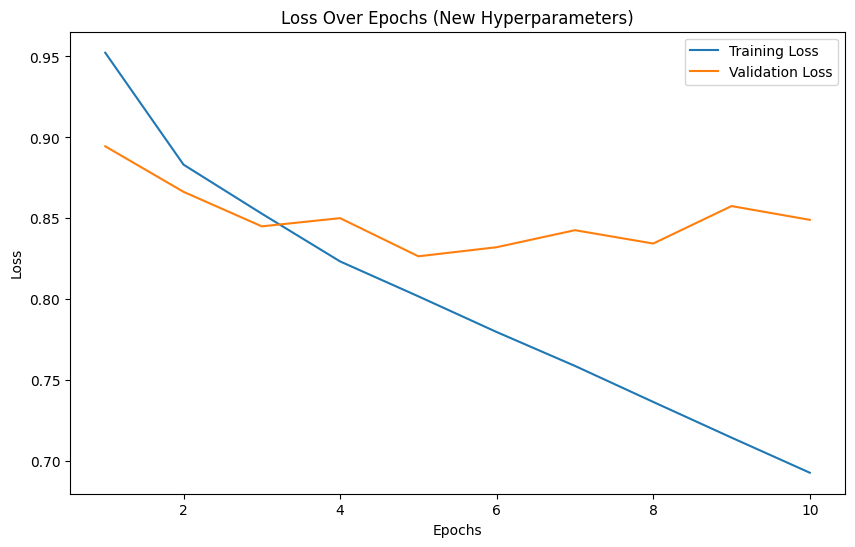

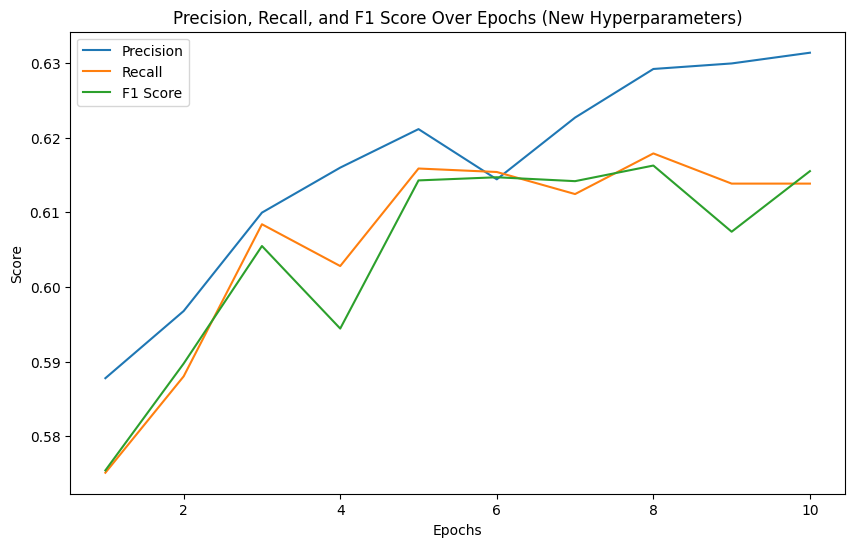

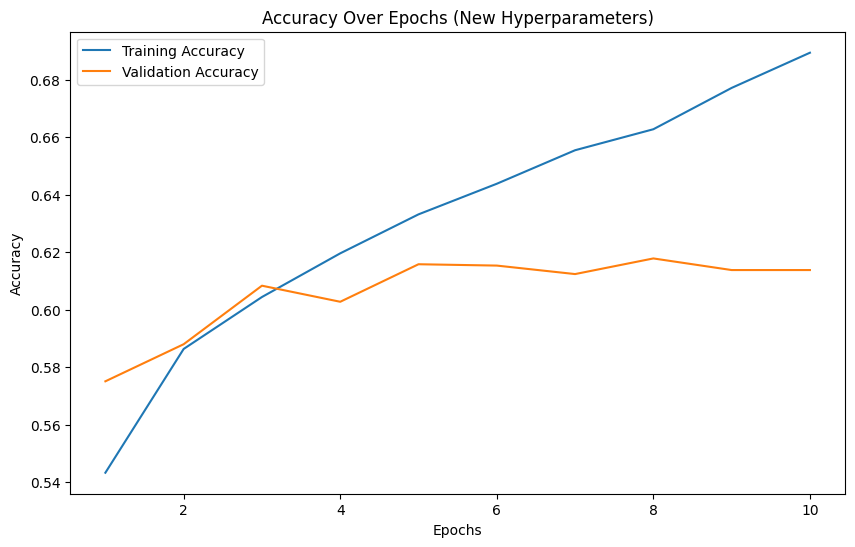

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Training and Evaluation
epochs = 10
results = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0

    start_time = time.time()

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / total_train
    training_time = time.time() - start_time

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
    inference_time = time.time() - start_time - training_time

    results.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "training_time": training_time,
        "inference_time": inference_time,
    })

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save Results
results_df = pd.DataFrame(results)
results_file_path = "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv"
results_df.to_csv(results_file_path, index=False)
print(f"Results saved to: {results_file_path}")

# Visualizations
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, [r["train_loss"] for r in results], label="Training Loss")
plt.plot(epochs_range, [r["val_loss"] for r in results], label="Validation Loss")
plt.title("Loss Over Epochs (New Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, [r["precision"] for r in results], label="Precision")
plt.plot(epochs_range, [r["recall"] for r in results], label="Recall")
plt.plot(epochs_range, [r["f1"] for r in results], label="F1 Score")
plt.title("Precision, Recall, and F1 Score Over Epochs (New Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, [r["train_accuracy"] for r in results], label="Training Accuracy")
plt.plot(epochs_range, [r["val_accuracy"] for r in results], label="Validation Accuracy")
plt.title("Accuracy Over Epochs (New Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Epoch 1/10
Epoch 1 - Train Loss: 0.9903, Train Accuracy: 0.5185
Epoch 2/10
Epoch 2 - Train Loss: 0.9265, Train Accuracy: 0.5581
Epoch 3/10
Epoch 3 - Train Loss: 0.9013, Train Accuracy: 0.5739
Epoch 4/10
Epoch 4 - Train Loss: 0.8841, Train Accuracy: 0.5877
Epoch 5/10
Epoch 5 - Train Loss: 0.8654, Train Accuracy: 0.5966
Epoch 6/10
Epoch 6 - Train Loss: 0.8525, Train Accuracy: 0.6035
Epoch 7/10
Epoch 7 - Train Loss: 0.8363, Train Accuracy: 0.6107
Epoch 8/10
Epoch 8 - Train Loss: 0.8245, Train Accuracy: 0.6194
Epoch 9/10
Epoch 9 - Train Loss: 0.8092, Train Accuracy: 0.6266
Epoch 10/10
Epoch 10 - Train Loss: 0.7996, Train Accuracy: 0.6324
Results saved to: /content/drive/My Drive/hybrid_model_first_hyperparams_results.csv


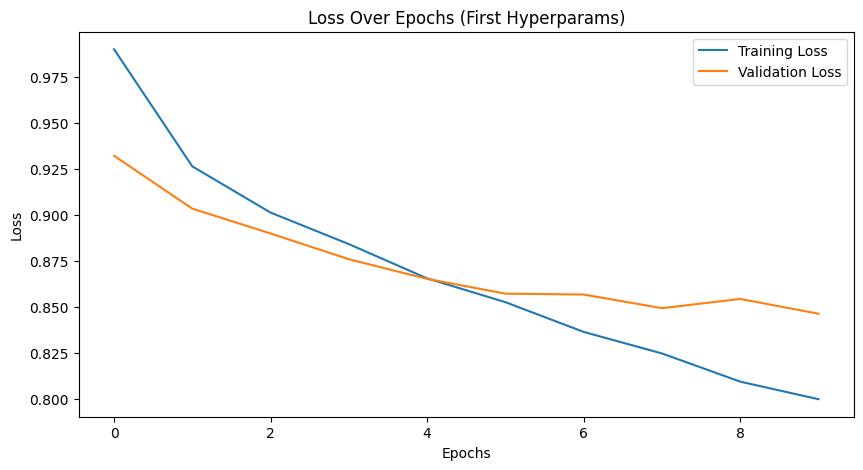

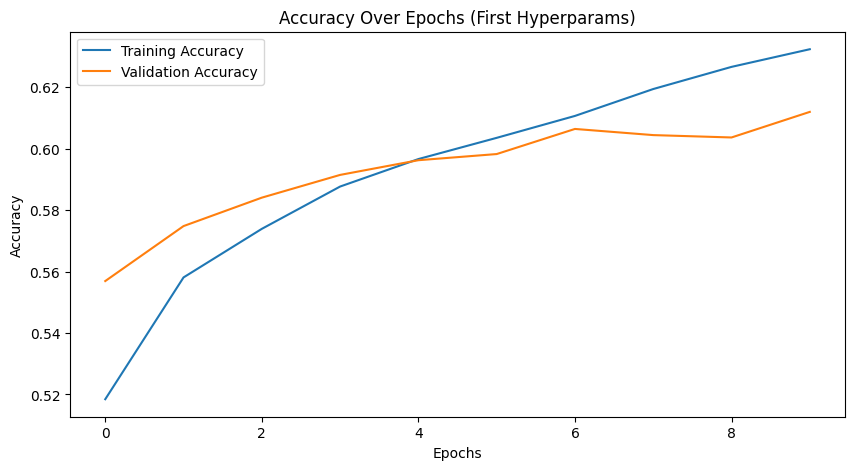

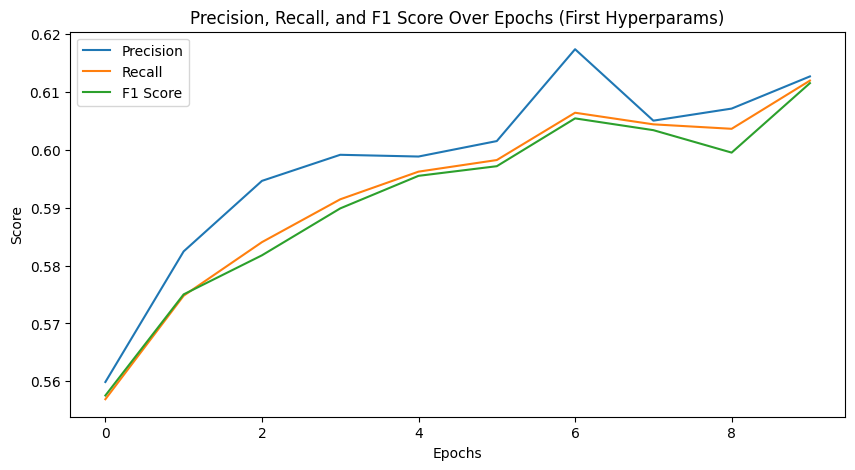

In [ ]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support
import time
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# File path for the original dataset
file_path = "/content/drive/My Drive/dataset.csv"

# Step 1: Load and Preprocess Dataset
df = pd.read_csv(file_path)
df = df.drop_duplicates()  # Remove duplicates
df = df.dropna(subset=["text", "sentiment"])  # Drop rows with null values

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return " ".join(tokens)

# Apply preprocessing
df["text"] = df["text"].astype(str).apply(preprocess_text)
df["label"] = df["sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})

# Step 2: Split data into training and testing sets (80/20 split)
split_idx = int(len(df) * 0.8)
train_texts, train_labels = df["text"][:split_idx].tolist(), df["label"][:split_idx].tolist()
test_texts, test_labels = df["text"][split_idx:].tolist(), df["label"][split_idx:].tolist()

# Step 3: Define Dataset Class and Hybrid Model
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

class HybridModel(nn.Module):
    def __init__(self, llm_name, hidden_dim, num_classes):
        super(HybridModel, self).__init__()
        self.llm = AutoModel.from_pretrained(llm_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            llm_outputs = self.llm(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = llm_outputs.last_hidden_state
        lstm_out, (hidden, _) = self.lstm(embeddings)
        pooled_output = hidden[-1]
        dropped_output = self.dropout(pooled_output)
        logits = self.fc(dropped_output)
        return logits

# Step 4: Initialize tokenizer, datasets, and model
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel("yiyanghkust/finbert-tone", hidden_dim=256, num_classes=3).to(device)

# Step 5: Define optimizer and loss function (First Hyperparameter Set)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)  # First set learning rate and weight decay
criterion = nn.CrossEntropyLoss()

# Step 6: Train and Evaluate the Model
epochs = 10
results = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0
    start_time = time.time()

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    training_time = time.time() - start_time
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=1)
    inference_time = time.time() - start_time - training_time

    results.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "training_time": training_time,
        "inference_time": inference_time,
    })

# Save results
results_df = pd.DataFrame(results)
results_file_path = "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv"
results_df.to_csv(results_file_path, index=False)
print(f"Results saved to: {results_file_path}")

# Visualization
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot([r["train_loss"] for r in results], label="Training Loss")
plt.plot([r["val_loss"] for r in results], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs (First Hyperparams)")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot([r["train_accuracy"] for r in results], label="Training Accuracy")
plt.plot([r["val_accuracy"] for r in results], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs (First Hyperparams)")
plt.legend()
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(10, 5))
plt.plot([r["precision"] for r in results], label="Precision")
plt.plot([r["recall"] for r in results], label="Recall")
plt.plot([r["f1"] for r in results], label="F1 Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score Over Epochs (First Hyperparams)")
plt.legend()
plt.show()


# Comparison of all three Hyperparameter set (Hybrid Models)

    epoch  train_loss  train_accuracy  val_loss  val_accuracy  precision  \
0       1    0.990289        0.518451  0.932248      0.556909   0.559884   
1       2    0.926470        0.558092  0.903443      0.574800   0.582459   
2       3    0.901295        0.573902  0.889906      0.584053   0.594643   
3       4    0.884120        0.587668  0.875897      0.591456   0.599149   
4       5    0.865439        0.596614  0.865170      0.596237   0.598848   
5       6    0.852488        0.603517  0.857133      0.598242   0.601520   
6       7    0.836282        0.610651  0.856643      0.606416   0.617392   
7       8    0.824550        0.619404  0.849214      0.604411   0.605047   
8       9    0.809192        0.626615  0.854255      0.603640   0.607134   
9      10    0.799617        0.632360  0.846207      0.611968   0.612693   
10      1    1.017215        0.496800  0.959338      0.546114   0.549234   
11      2    0.952312        0.546036  0.928530      0.559685   0.564784   
12      3   

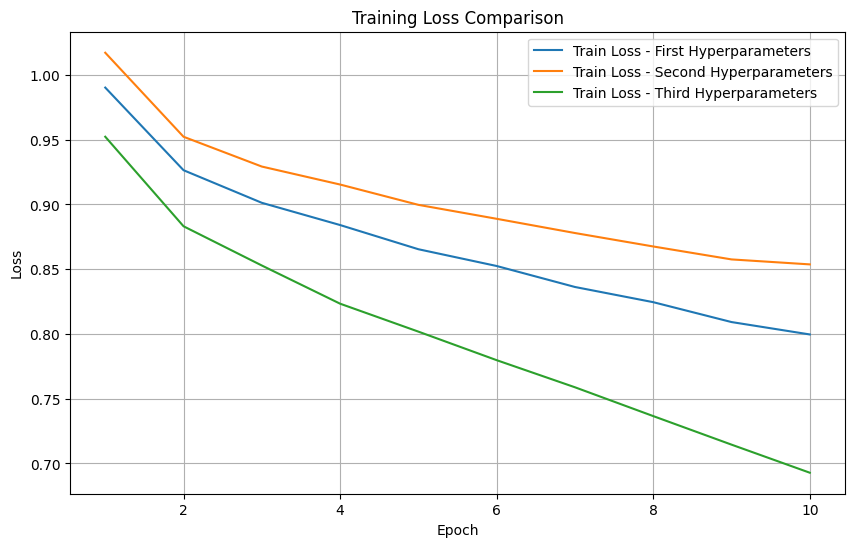

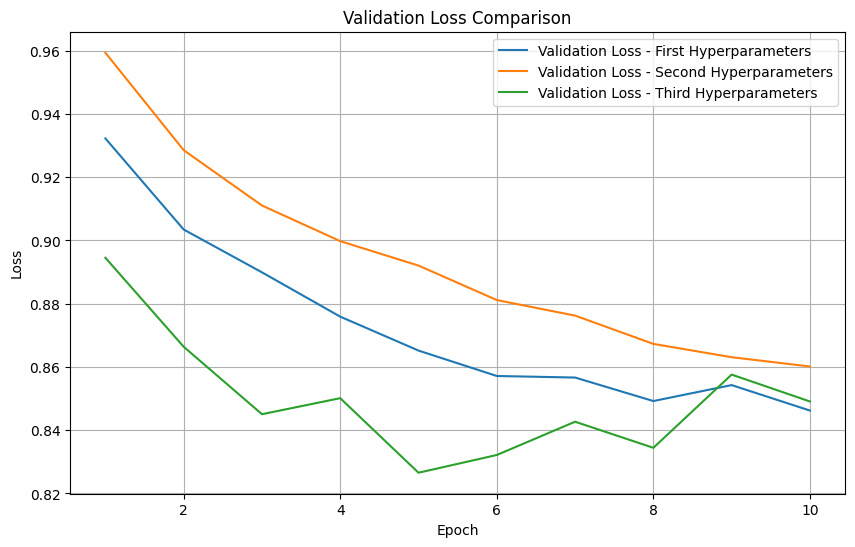

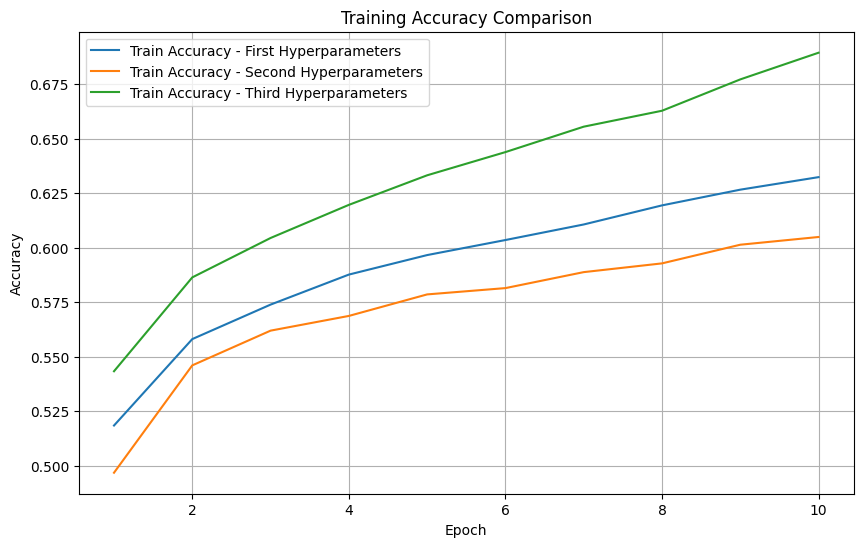

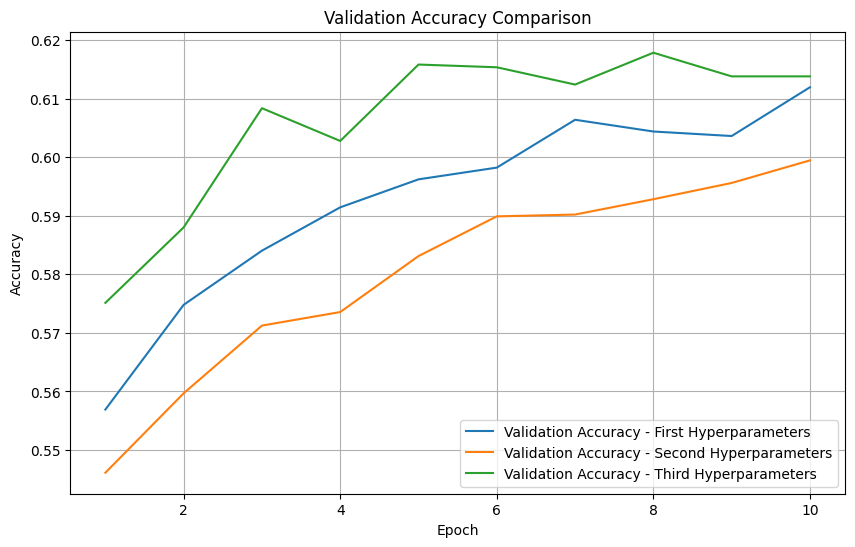

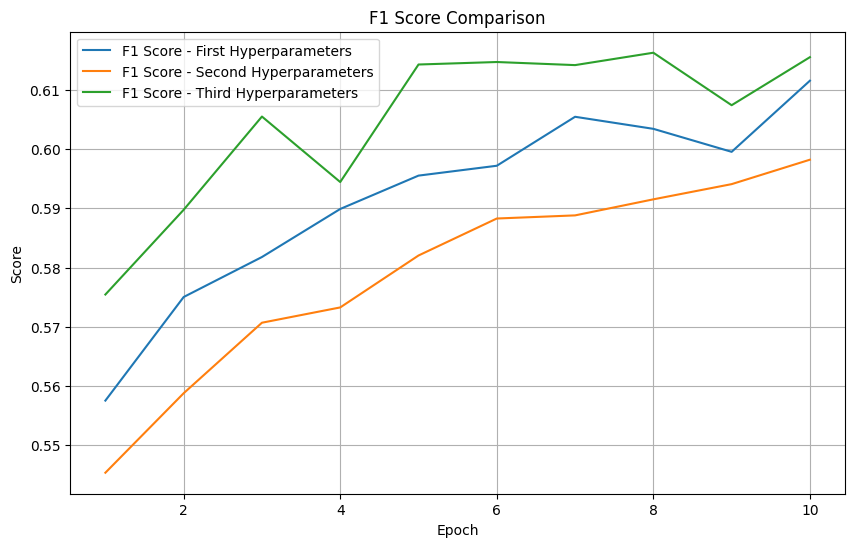

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results files
file_paths = [
    "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv",
    "/content/drive/My Drive/hybrid_model_results_new_params.csv",
    "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv",
]

results_data = [pd.read_csv(file) for file in file_paths]
labels = ["First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Merge data into a single DataFrame for comparison
comparison_df = pd.concat(
    [df.assign(Hyperparams=label) for df, label in zip(results_data, labels)],
    ignore_index=True,
)

# Display the combined dataframe for verification
print(comparison_df)

# Plot comparison visuals
# 1. Training Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_loss"], label=f"Train Loss - {label}")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_loss"], label=f"Validation Loss - {label}")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 3. Training Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_accuracy"], label=f"Train Accuracy - {label}")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 4. Validation Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_accuracy"], label=f"Validation Accuracy - {label}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 5. F1 Score
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["f1"], label=f"F1 Score - {label}")
plt.title("F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()


    epoch  train_loss  train_accuracy  val_loss  val_accuracy  precision  \
0       1    0.990289        0.518451  0.932248      0.556909   0.559884   
1       2    0.926470        0.558092  0.903443      0.574800   0.582459   
2       3    0.901295        0.573902  0.889906      0.584053   0.594643   
3       4    0.884120        0.587668  0.875897      0.591456   0.599149   
4       5    0.865439        0.596614  0.865170      0.596237   0.598848   
5       6    0.852488        0.603517  0.857133      0.598242   0.601520   
6       7    0.836282        0.610651  0.856643      0.606416   0.617392   
7       8    0.824550        0.619404  0.849214      0.604411   0.605047   
8       9    0.809192        0.626615  0.854255      0.603640   0.607134   
9      10    0.799617        0.632360  0.846207      0.611968   0.612693   
10      1    1.017215        0.496800  0.959338      0.546114   0.549234   
11      2    0.952312        0.546036  0.928530      0.559685   0.564784   
12      3   

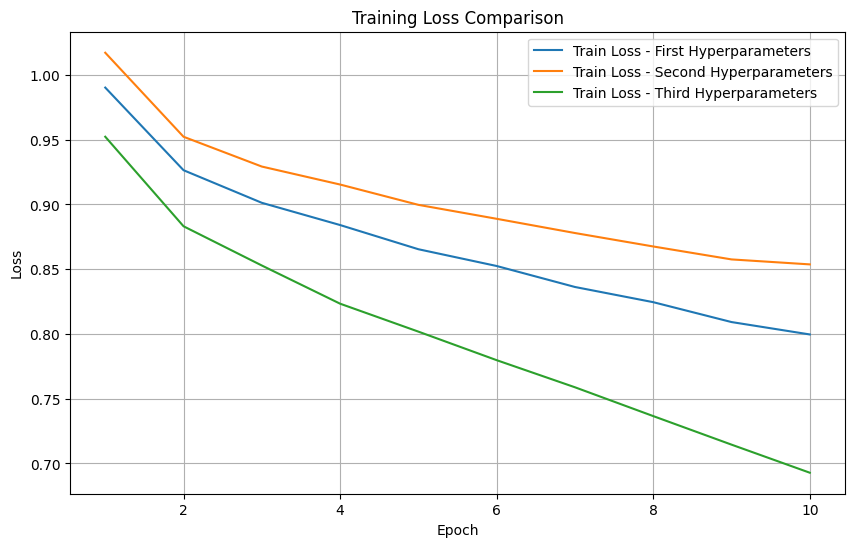

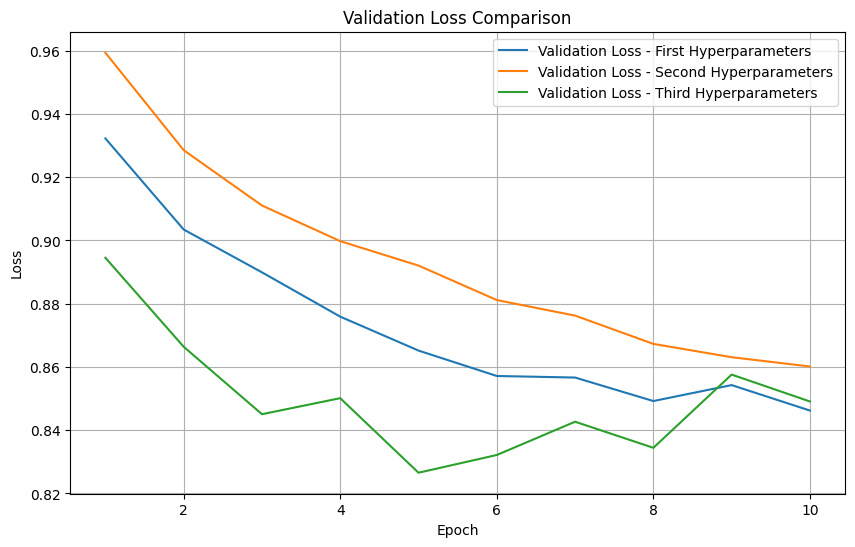

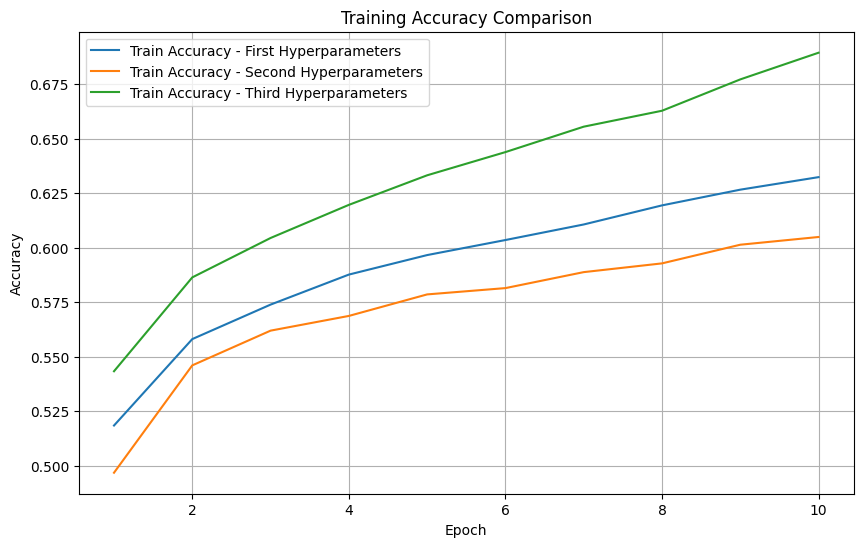

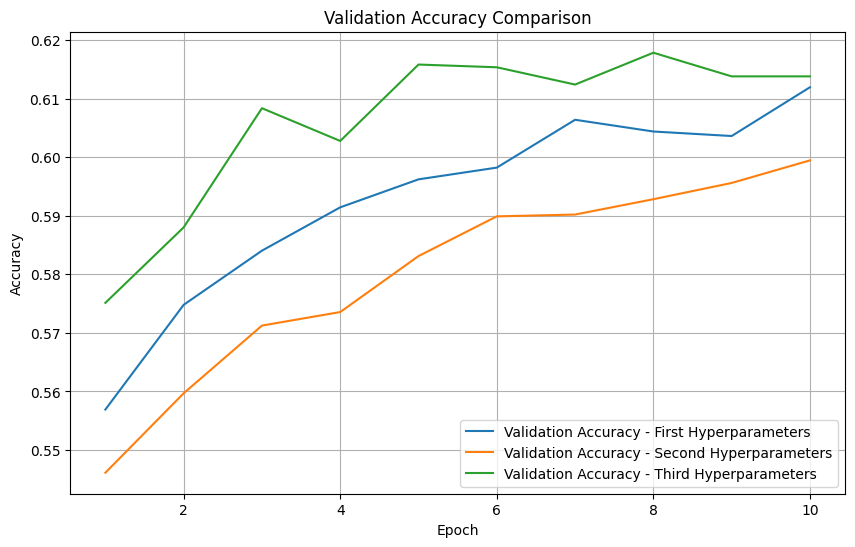

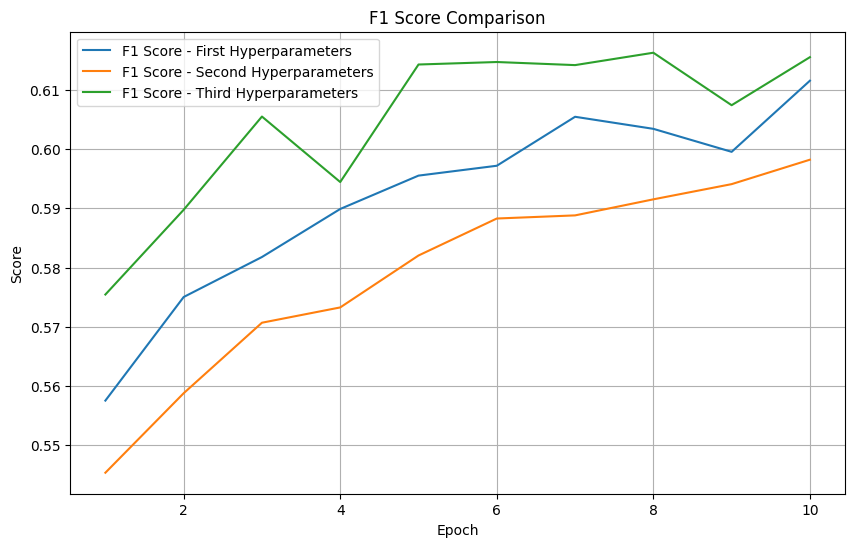

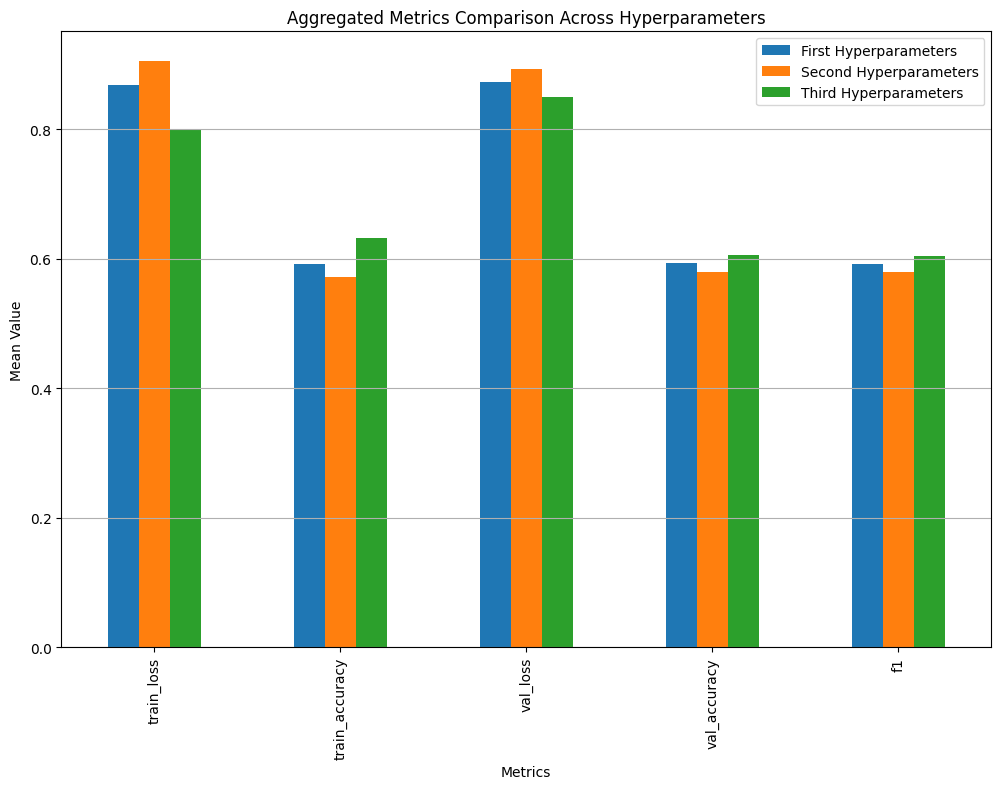

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results files
file_paths = [
    "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv",
    "/content/drive/My Drive/hybrid_model_results_new_params.csv",
    "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv",
]

results_data = [pd.read_csv(file) for file in file_paths]
labels = ["First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Merge data into a single DataFrame for comparison
comparison_df = pd.concat(
    [df.assign(Hyperparams=label) for df, label in zip(results_data, labels)],
    ignore_index=True,
)

# Display the combined dataframe for verification
print(comparison_df)

# Plot comparison visuals
# 1. Training Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_loss"], label=f"Train Loss - {label}")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_loss"], label=f"Validation Loss - {label}")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 3. Training Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_accuracy"], label=f"Train Accuracy - {label}")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 4. Validation Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_accuracy"], label=f"Validation Accuracy - {label}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 5. F1 Score
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["f1"], label=f"F1 Score - {label}")
plt.title("F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# 6. Aggregated Metrics Comparison (Bar Chart)
metrics = ["train_loss", "train_accuracy", "val_loss", "val_accuracy", "f1"]
aggregated_results = {
    "Metric": [],
    "First Hyperparameters": [],
    "Second Hyperparameters": [],
    "Third Hyperparameters": [],
}

for metric in metrics:
    aggregated_results["Metric"].append(metric)
    aggregated_results["First Hyperparameters"].append(results_data[0][metric].mean())
    aggregated_results["Second Hyperparameters"].append(results_data[1][metric].mean())
    aggregated_results["Third Hyperparameters"].append(results_data[2][metric].mean())

aggregated_df = pd.DataFrame(aggregated_results)

# Plot bar chart for comparison
aggregated_df.set_index("Metric").plot(
    kind="bar", figsize=(12, 8), color=["#1f77b4", "#ff7f0e", "#2ca02c"]
)
plt.title("Aggregated Metrics Comparison Across Hyperparameters")
plt.xlabel("Metrics")
plt.ylabel("Mean Value")
plt.legend(loc="best")
plt.grid(axis="y")
plt.show()


    epoch  train_loss  train_accuracy  val_loss  val_accuracy  precision  \
0       1    0.990289        0.518451  0.932248      0.556909   0.559884   
1       2    0.926470        0.558092  0.903443      0.574800   0.582459   
2       3    0.901295        0.573902  0.889906      0.584053   0.594643   
3       4    0.884120        0.587668  0.875897      0.591456   0.599149   
4       5    0.865439        0.596614  0.865170      0.596237   0.598848   
5       6    0.852488        0.603517  0.857133      0.598242   0.601520   
6       7    0.836282        0.610651  0.856643      0.606416   0.617392   
7       8    0.824550        0.619404  0.849214      0.604411   0.605047   
8       9    0.809192        0.626615  0.854255      0.603640   0.607134   
9      10    0.799617        0.632360  0.846207      0.611968   0.612693   
10      1    1.017215        0.496800  0.959338      0.546114   0.549234   
11      2    0.952312        0.546036  0.928530      0.559685   0.564784   
12      3   

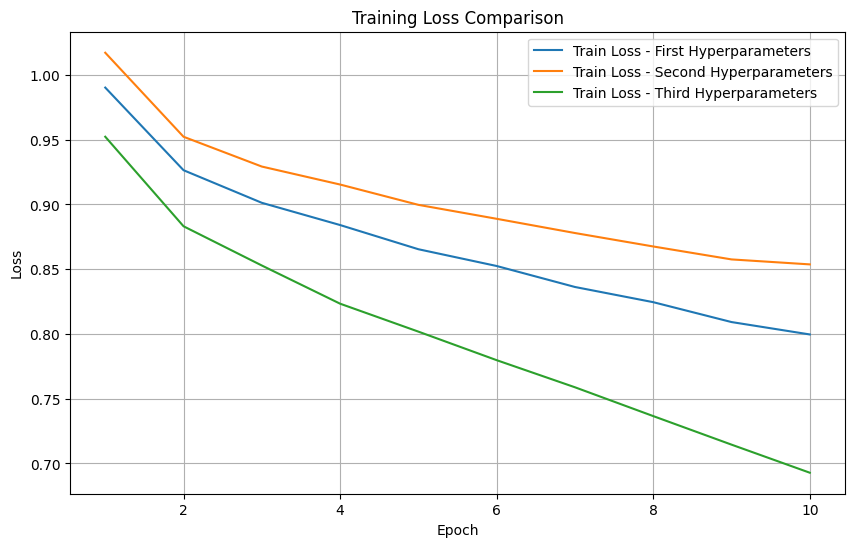

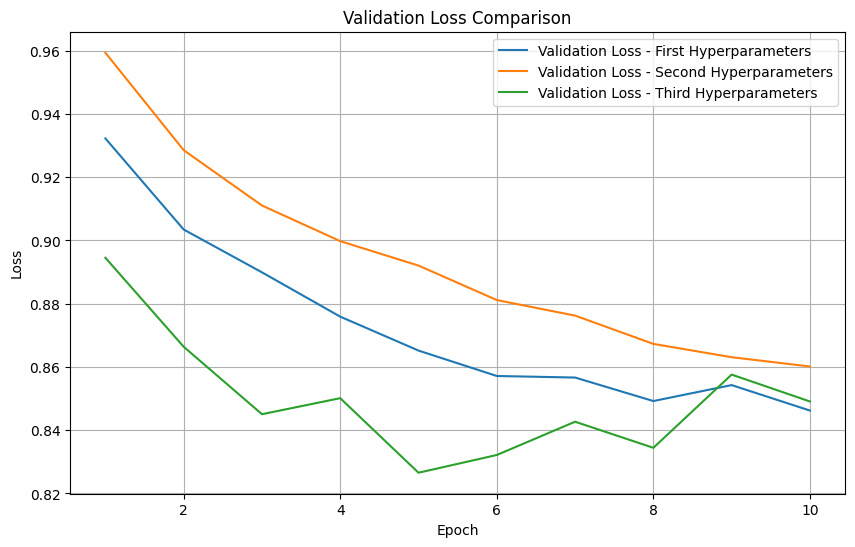

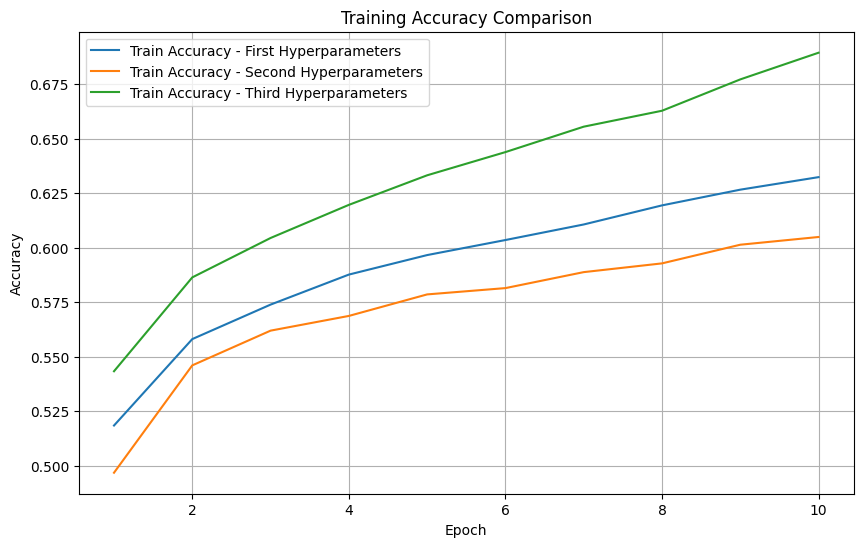

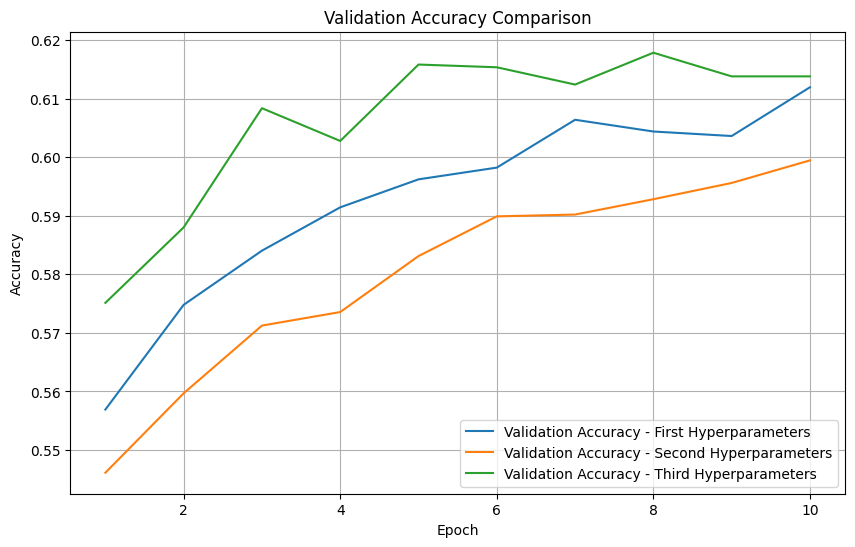

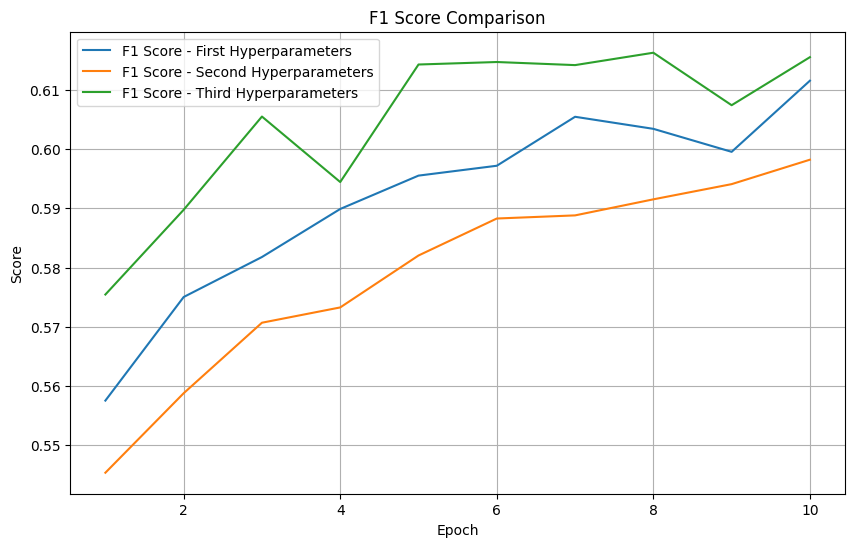

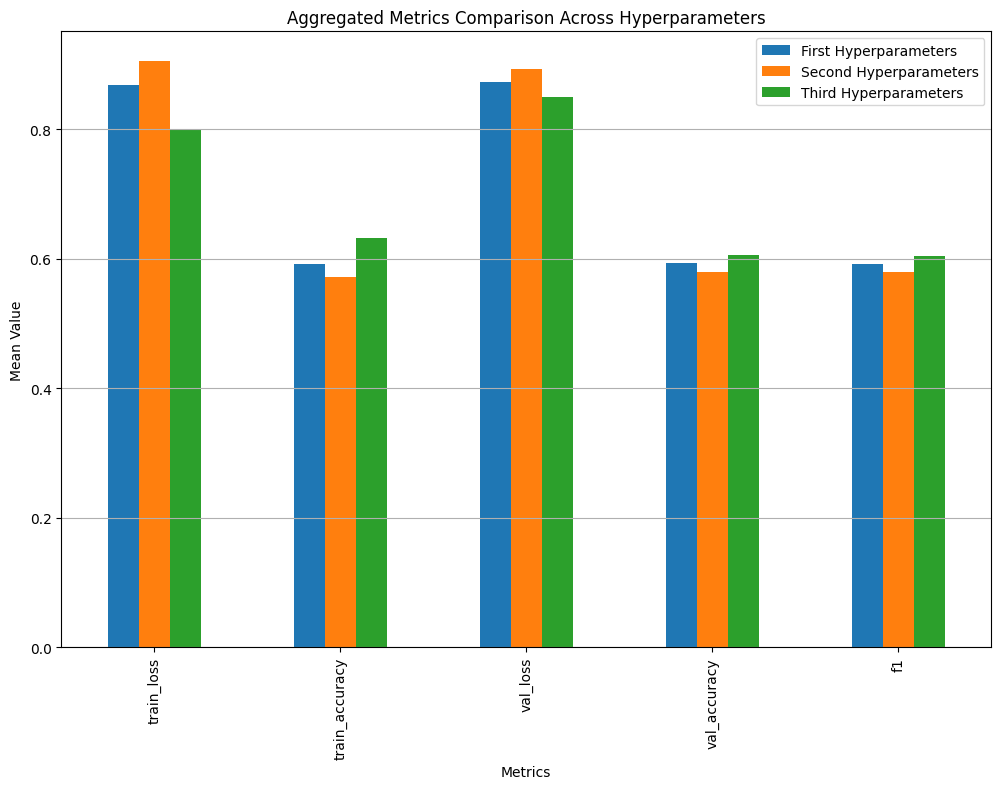

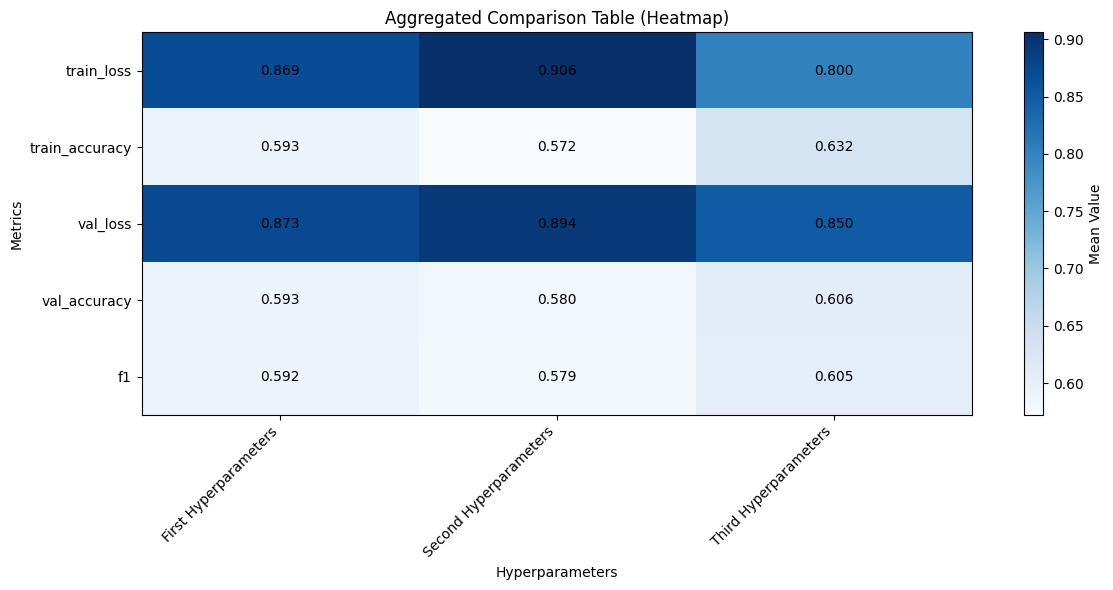

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results files
file_paths = [
    "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv",
    "/content/drive/My Drive/hybrid_model_results_new_params.csv",
    "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv",
]

results_data = [pd.read_csv(file) for file in file_paths]
labels = ["First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Merge data into a single DataFrame for comparison
comparison_df = pd.concat(
    [df.assign(Hyperparams=label) for df, label in zip(results_data, labels)],
    ignore_index=True,
)

# Display the combined dataframe for verification
print(comparison_df)

# Plot comparison visuals
# 1. Training Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_loss"], label=f"Train Loss - {label}")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_loss"], label=f"Validation Loss - {label}")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 3. Training Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_accuracy"], label=f"Train Accuracy - {label}")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 4. Validation Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_accuracy"], label=f"Validation Accuracy - {label}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 5. F1 Score
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["f1"], label=f"F1 Score - {label}")
plt.title("F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# 6. Aggregated Metrics Comparison (Bar Chart)
metrics = ["train_loss", "train_accuracy", "val_loss", "val_accuracy", "f1"]
aggregated_results = {
    "Metric": [],
    "First Hyperparameters": [],
    "Second Hyperparameters": [],
    "Third Hyperparameters": [],
}

for metric in metrics:
    aggregated_results["Metric"].append(metric)
    aggregated_results["First Hyperparameters"].append(results_data[0][metric].mean())
    aggregated_results["Second Hyperparameters"].append(results_data[1][metric].mean())
    aggregated_results["Third Hyperparameters"].append(results_data[2][metric].mean())

aggregated_df = pd.DataFrame(aggregated_results)

# Plot bar chart for comparison
aggregated_df.set_index("Metric").plot(
    kind="bar", figsize=(12, 8), color=["#1f77b4", "#ff7f0e", "#2ca02c"]
)
plt.title("Aggregated Metrics Comparison Across Hyperparameters")
plt.xlabel("Metrics")
plt.ylabel("Mean Value")
plt.legend(loc="best")
plt.grid(axis="y")
plt.show()

# 7. Aggregated Comparison Table (Heatmap-like Visual)
fig, ax = plt.subplots(figsize=(12, 6))
table_data = aggregated_df.set_index("Metric")
cmap = plt.cm.Blues

# Create a heatmap-like table visualization
im = ax.imshow(table_data.values, cmap=cmap, aspect="auto")

# Add labels and formatting
ax.set_xticks(range(table_data.shape[1]))
ax.set_yticks(range(table_data.shape[0]))
ax.set_xticklabels(table_data.columns, rotation=45, ha="right")
ax.set_yticklabels(table_data.index)
plt.colorbar(im, ax=ax, orientation="vertical", label="Mean Value")

# Annotate each cell with the value
for i in range(table_data.shape[0]):
    for j in range(table_data.shape[1]):
        ax.text(j, i, f"{table_data.iloc[i, j]:.3f}", ha="center", va="center", color="black")

plt.title("Aggregated Comparison Table (Heatmap)")
plt.xlabel("Hyperparameters")
plt.ylabel("Metrics")
plt.tight_layout()
plt.show()


    epoch  train_loss  train_accuracy  val_loss  val_accuracy  precision  \
0       1    0.990289        0.518451  0.932248      0.556909   0.559884   
1       2    0.926470        0.558092  0.903443      0.574800   0.582459   
2       3    0.901295        0.573902  0.889906      0.584053   0.594643   
3       4    0.884120        0.587668  0.875897      0.591456   0.599149   
4       5    0.865439        0.596614  0.865170      0.596237   0.598848   
5       6    0.852488        0.603517  0.857133      0.598242   0.601520   
6       7    0.836282        0.610651  0.856643      0.606416   0.617392   
7       8    0.824550        0.619404  0.849214      0.604411   0.605047   
8       9    0.809192        0.626615  0.854255      0.603640   0.607134   
9      10    0.799617        0.632360  0.846207      0.611968   0.612693   
10      1    1.017215        0.496800  0.959338      0.546114   0.549234   
11      2    0.952312        0.546036  0.928530      0.559685   0.564784   
12      3   

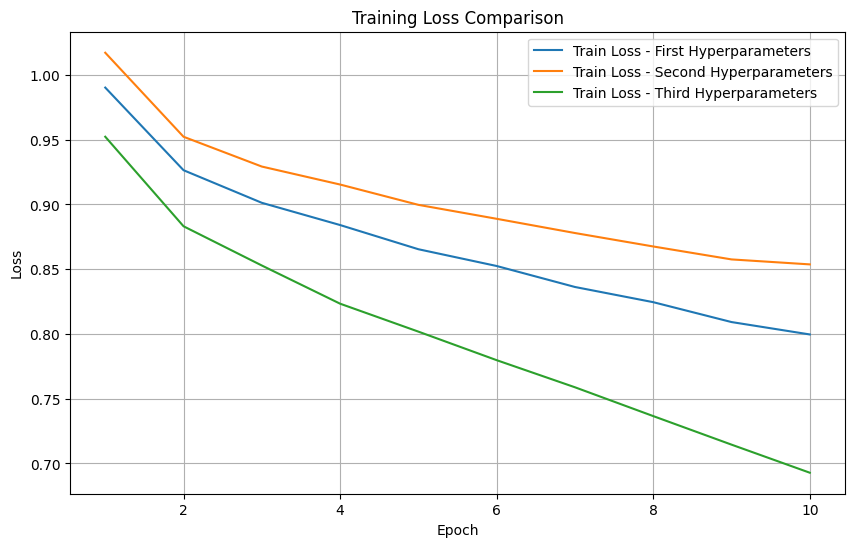

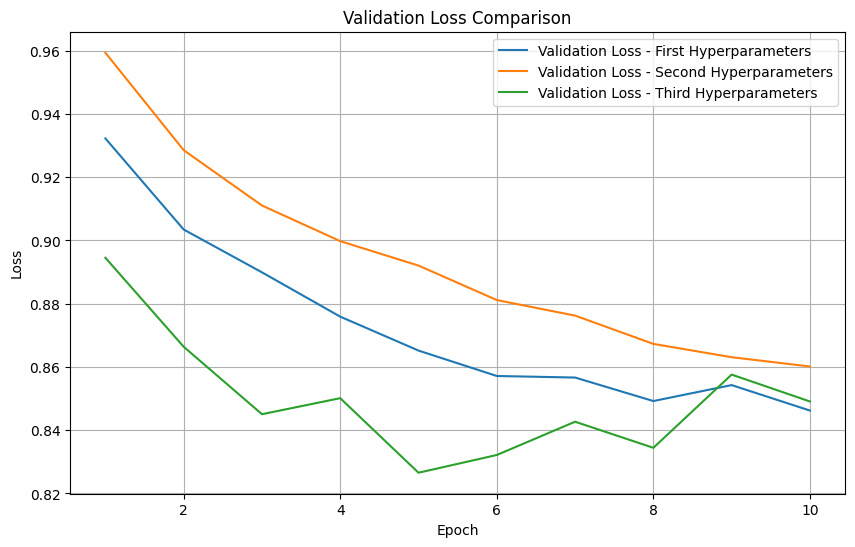

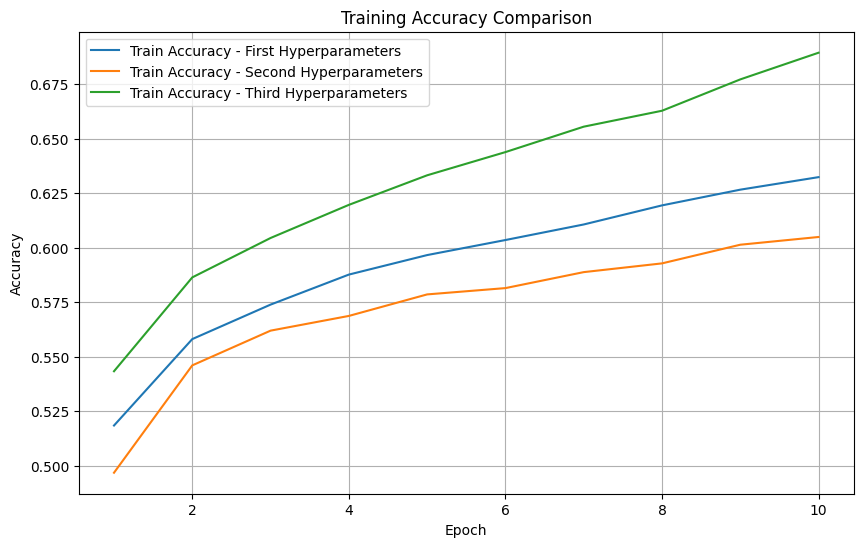

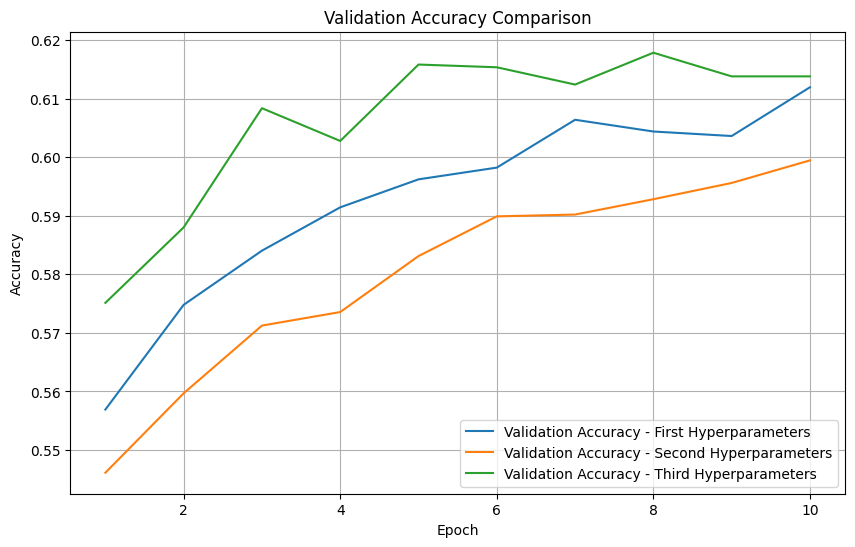

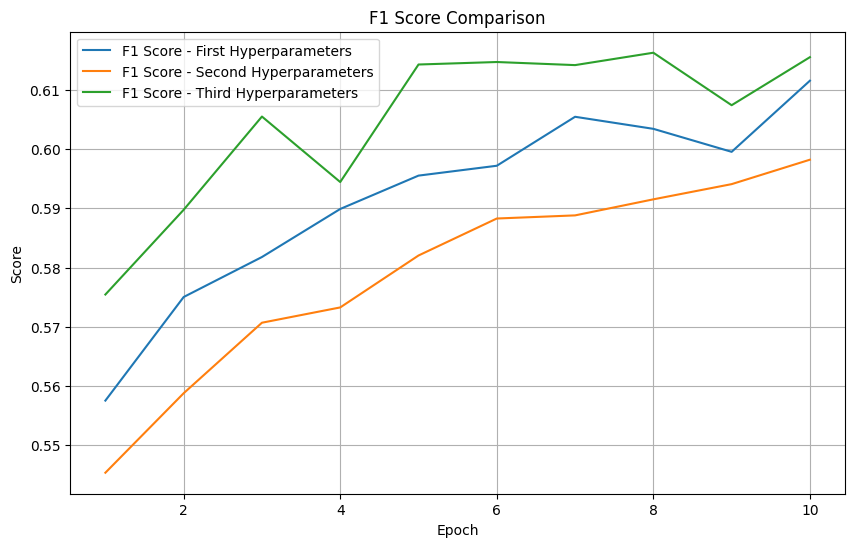

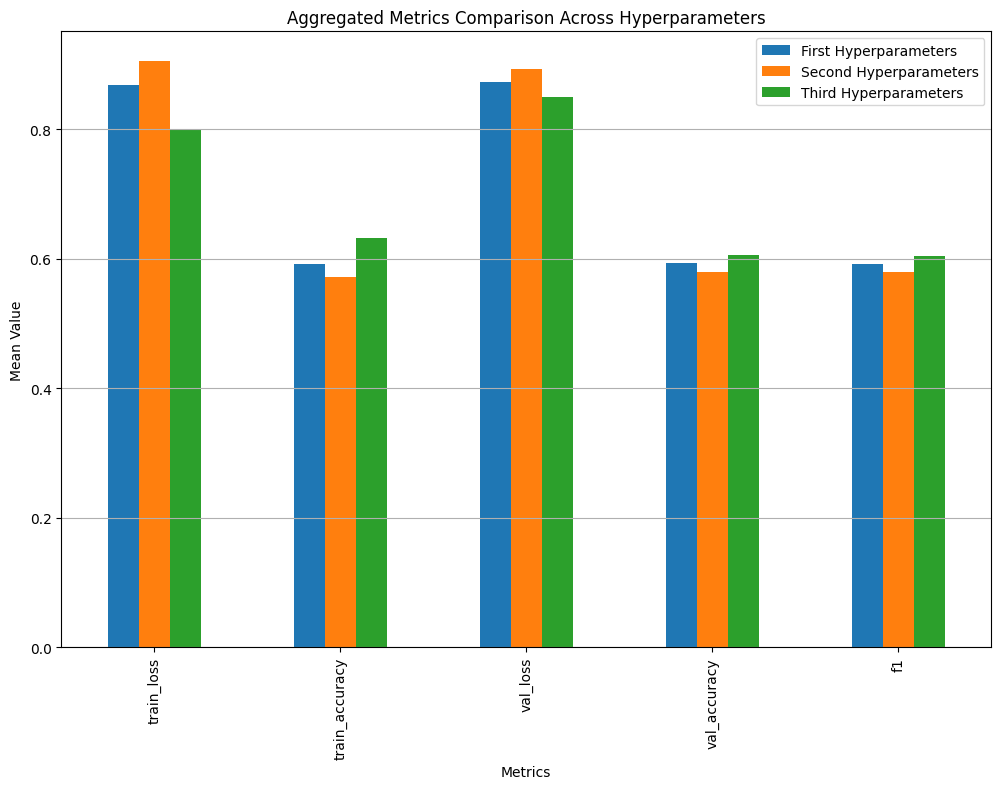

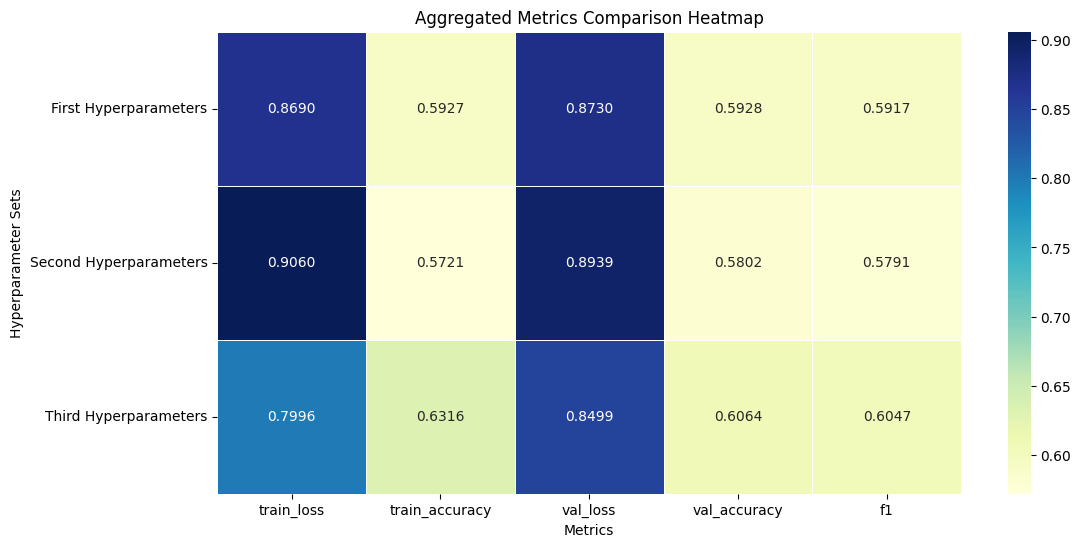

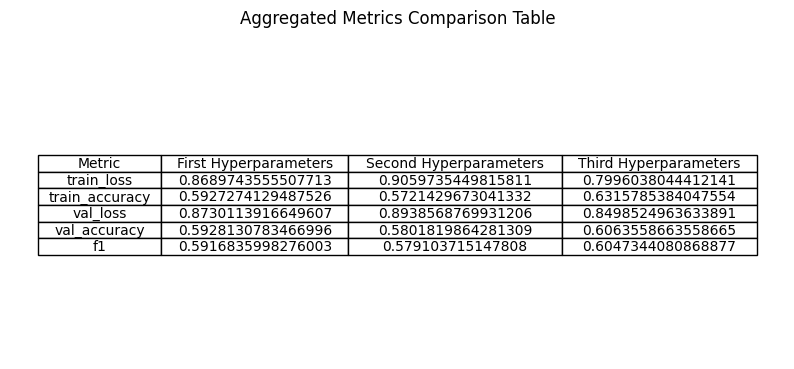

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For the heatmap

# Load the results files
file_paths = [
    "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv",
    "/content/drive/My Drive/hybrid_model_results_new_params.csv",
    "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv",
]

results_data = [pd.read_csv(file) for file in file_paths]
labels = ["First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Merge data into a single DataFrame for comparison
comparison_df = pd.concat(
    [df.assign(Hyperparams=label) for df, label in zip(results_data, labels)],
    ignore_index=True,
)

# Display the combined dataframe for verification
print(comparison_df)

# Plot comparison visuals
# 1. Training Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_loss"], label=f"Train Loss - {label}")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_loss"], label=f"Validation Loss - {label}")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 3. Training Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_accuracy"], label=f"Train Accuracy - {label}")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 4. Validation Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_accuracy"], label=f"Validation Accuracy - {label}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 5. F1 Score
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["f1"], label=f"F1 Score - {label}")
plt.title("F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# 6. Aggregated Metrics Comparison (Bar Chart)
metrics = ["train_loss", "train_accuracy", "val_loss", "val_accuracy", "f1"]
aggregated_results = {
    "Metric": [],
    "First Hyperparameters": [],
    "Second Hyperparameters": [],
    "Third Hyperparameters": [],
}

for metric in metrics:
    aggregated_results["Metric"].append(metric)
    aggregated_results["First Hyperparameters"].append(results_data[0][metric].mean())
    aggregated_results["Second Hyperparameters"].append(results_data[1][metric].mean())
    aggregated_results["Third Hyperparameters"].append(results_data[2][metric].mean())

aggregated_df = pd.DataFrame(aggregated_results)

# Plot bar chart for comparison
aggregated_df.set_index("Metric").plot(
    kind="bar", figsize=(12, 8), color=["#1f77b4", "#ff7f0e", "#2ca02c"]
)
plt.title("Aggregated Metrics Comparison Across Hyperparameters")
plt.xlabel("Metrics")
plt.ylabel("Mean Value")
plt.legend(loc="best")
plt.grid(axis="y")
plt.show()

# 7. Aggregated Comparison Table (Heatmap)
# Prepare data for heatmap
heatmap_data = aggregated_df.set_index("Metric").transpose()

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
)
plt.title("Aggregated Metrics Comparison Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Hyperparameter Sets")
plt.show()

# 8. Aggregated Comparison Table (Plain Table)
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis("off")
ax.axis("tight")

# Convert the aggregated dataframe to a table
table_data = aggregated_df.values
column_labels = aggregated_df.columns
row_labels = aggregated_df["Metric"]

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(column_labels))))

ax.set_title("Aggregated Metrics Comparison Table", fontsize=12, pad=20)
plt.show()


    epoch  train_loss  train_accuracy  val_loss  val_accuracy  precision  \
0       1    0.990289        0.518451  0.932248      0.556909   0.559884   
1       2    0.926470        0.558092  0.903443      0.574800   0.582459   
2       3    0.901295        0.573902  0.889906      0.584053   0.594643   
3       4    0.884120        0.587668  0.875897      0.591456   0.599149   
4       5    0.865439        0.596614  0.865170      0.596237   0.598848   
5       6    0.852488        0.603517  0.857133      0.598242   0.601520   
6       7    0.836282        0.610651  0.856643      0.606416   0.617392   
7       8    0.824550        0.619404  0.849214      0.604411   0.605047   
8       9    0.809192        0.626615  0.854255      0.603640   0.607134   
9      10    0.799617        0.632360  0.846207      0.611968   0.612693   
10      1    1.017215        0.496800  0.959338      0.546114   0.549234   
11      2    0.952312        0.546036  0.928530      0.559685   0.564784   
12      3   

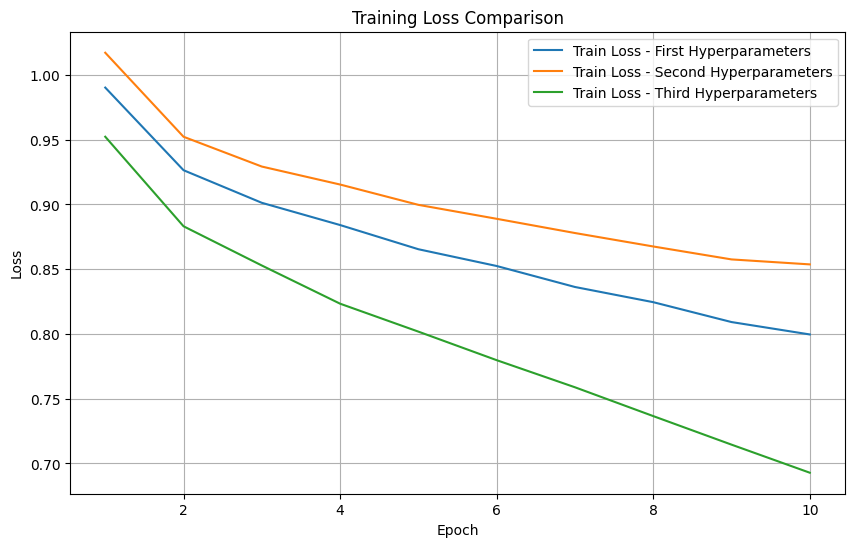

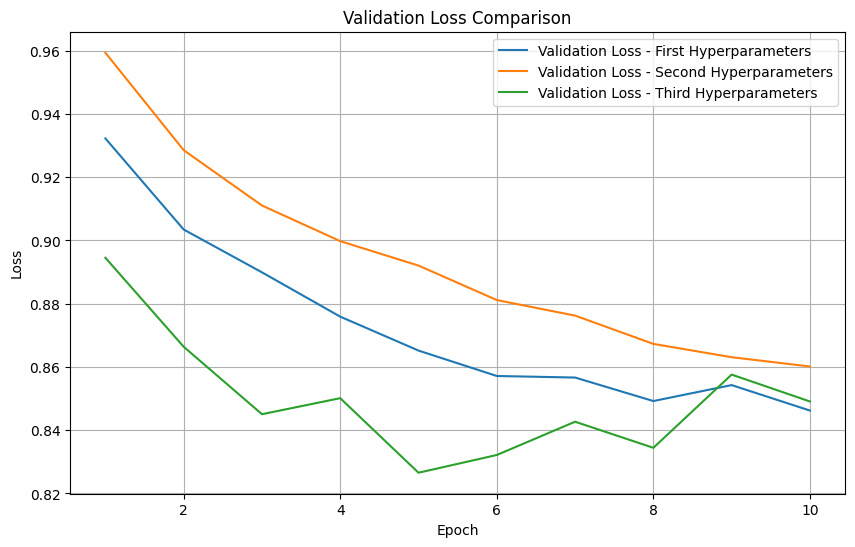

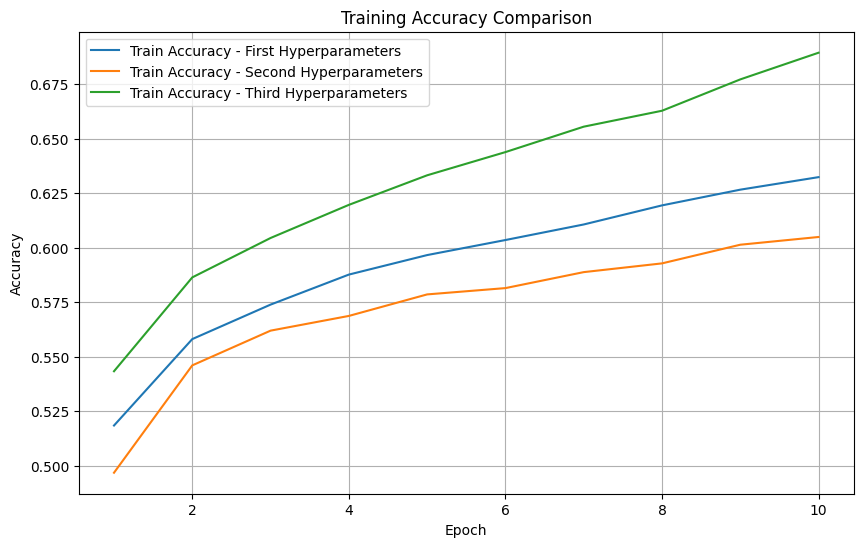

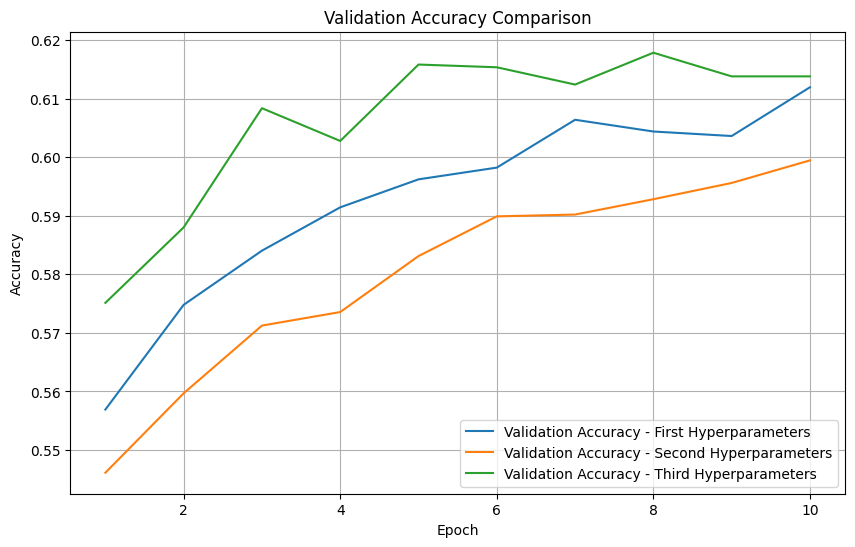

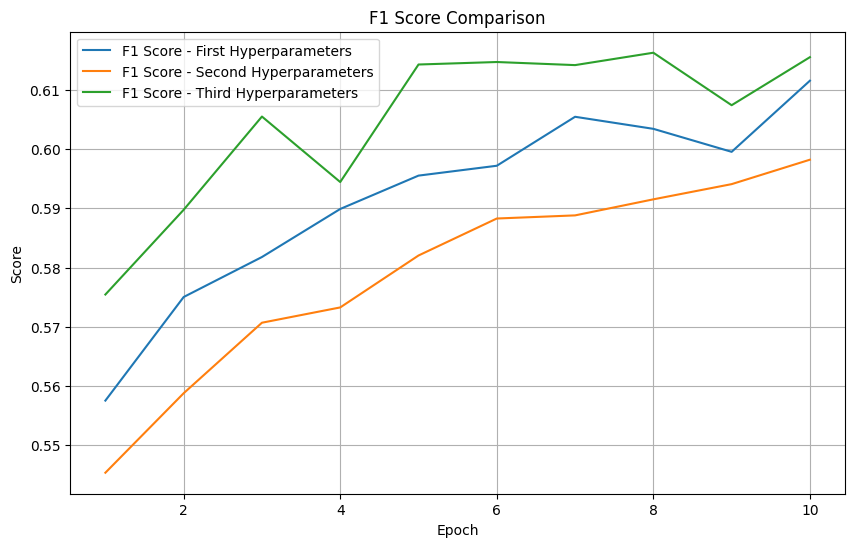

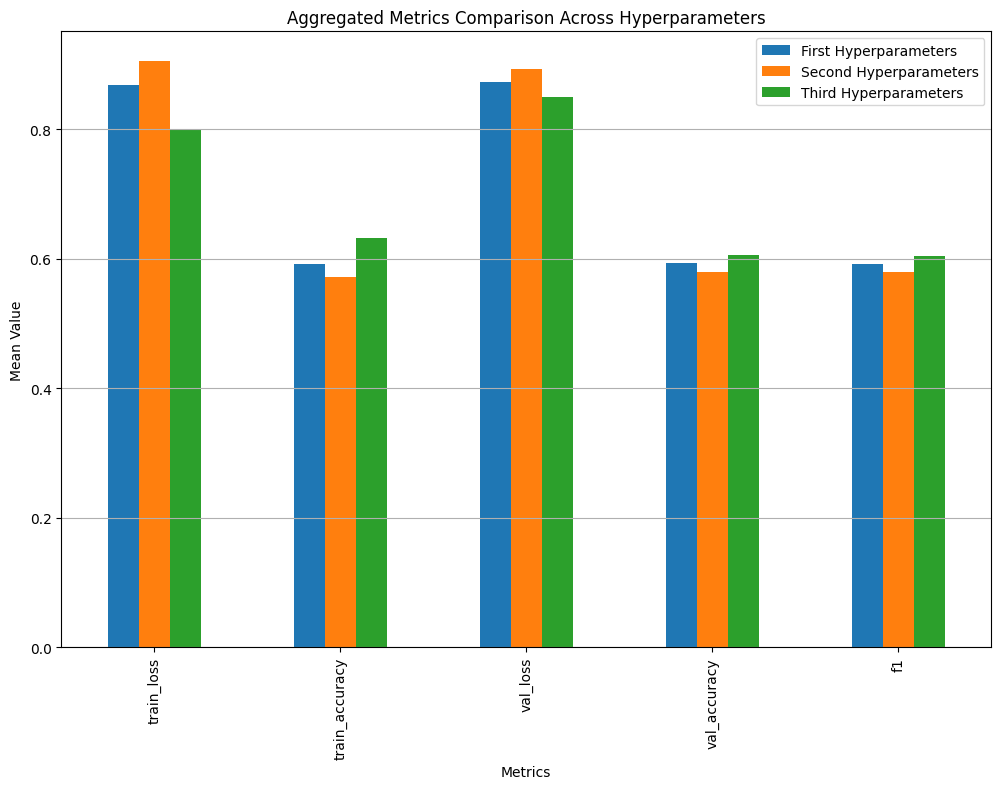

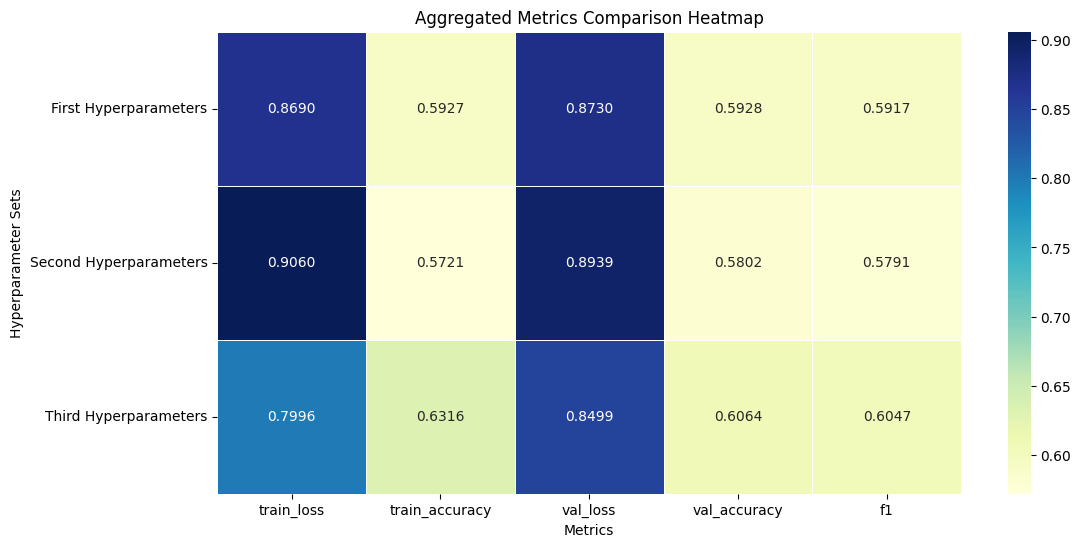

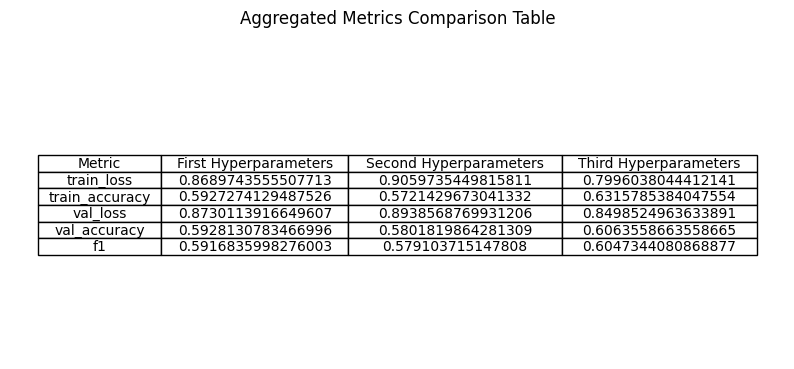

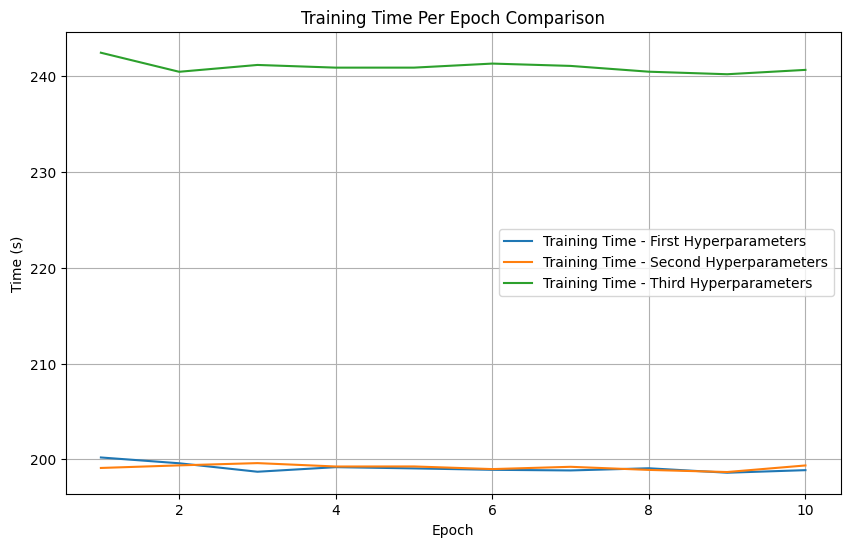

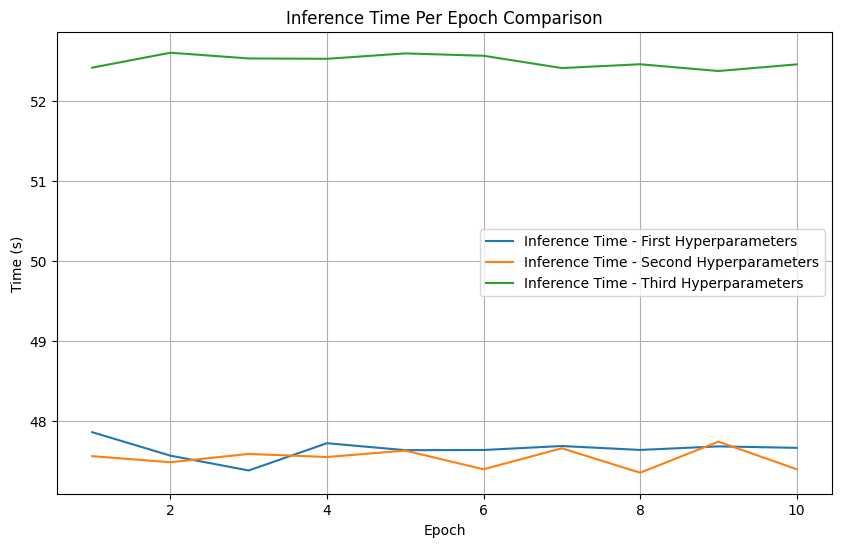

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For the heatmap

# Load the results files
file_paths = [
    "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv",
    "/content/drive/My Drive/hybrid_model_results_new_params.csv",
    "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv",
]

results_data = [pd.read_csv(file) for file in file_paths]
labels = ["First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Merge data into a single DataFrame for comparison
comparison_df = pd.concat(
    [df.assign(Hyperparams=label) for df, label in zip(results_data, labels)],
    ignore_index=True,
)

# Display the combined dataframe for verification
print(comparison_df)

# Plot comparison visuals
# 1. Training Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_loss"], label=f"Train Loss - {label}")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_loss"], label=f"Validation Loss - {label}")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 3. Training Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["train_accuracy"], label=f"Train Accuracy - {label}")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 4. Validation Accuracy
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["val_accuracy"], label=f"Validation Accuracy - {label}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# 5. F1 Score
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["f1"], label=f"F1 Score - {label}")
plt.title("F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# 6. Aggregated Metrics Comparison (Bar Chart)
metrics = ["train_loss", "train_accuracy", "val_loss", "val_accuracy", "f1"]
aggregated_results = {
    "Metric": [],
    "First Hyperparameters": [],
    "Second Hyperparameters": [],
    "Third Hyperparameters": [],
}

for metric in metrics:
    aggregated_results["Metric"].append(metric)
    aggregated_results["First Hyperparameters"].append(results_data[0][metric].mean())
    aggregated_results["Second Hyperparameters"].append(results_data[1][metric].mean())
    aggregated_results["Third Hyperparameters"].append(results_data[2][metric].mean())

aggregated_df = pd.DataFrame(aggregated_results)

# Plot bar chart for comparison
aggregated_df.set_index("Metric").plot(
    kind="bar", figsize=(12, 8), color=["#1f77b4", "#ff7f0e", "#2ca02c"]
)
plt.title("Aggregated Metrics Comparison Across Hyperparameters")
plt.xlabel("Metrics")
plt.ylabel("Mean Value")
plt.legend(loc="best")
plt.grid(axis="y")
plt.show()

# 7. Aggregated Comparison Table (Heatmap)
# Prepare data for heatmap
heatmap_data = aggregated_df.set_index("Metric").transpose()

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5,
)
plt.title("Aggregated Metrics Comparison Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Hyperparameter Sets")
plt.show()

# 8. Aggregated Comparison Table (Plain Table)
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis("off")
ax.axis("tight")

# Convert the aggregated dataframe to a table
table_data = aggregated_df.values
column_labels = aggregated_df.columns
row_labels = aggregated_df["Metric"]

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(column_labels))))

ax.set_title("Aggregated Metrics Comparison Table", fontsize=12, pad=20)
plt.show()

# 9. Training Time Comparison
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["training_time"], label=f"Training Time - {label}")
plt.title("Training Time Per Epoch Comparison")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.legend()
plt.grid()
plt.show()

# 10. Inference Time Comparison
plt.figure(figsize=(10, 6))
for df, label in zip(results_data, labels):
    plt.plot(df["epoch"], df["inference_time"], label=f"Inference Time - {label}")
plt.title("Inference Time Per Epoch Comparison")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.legend()
plt.grid()
plt.show()


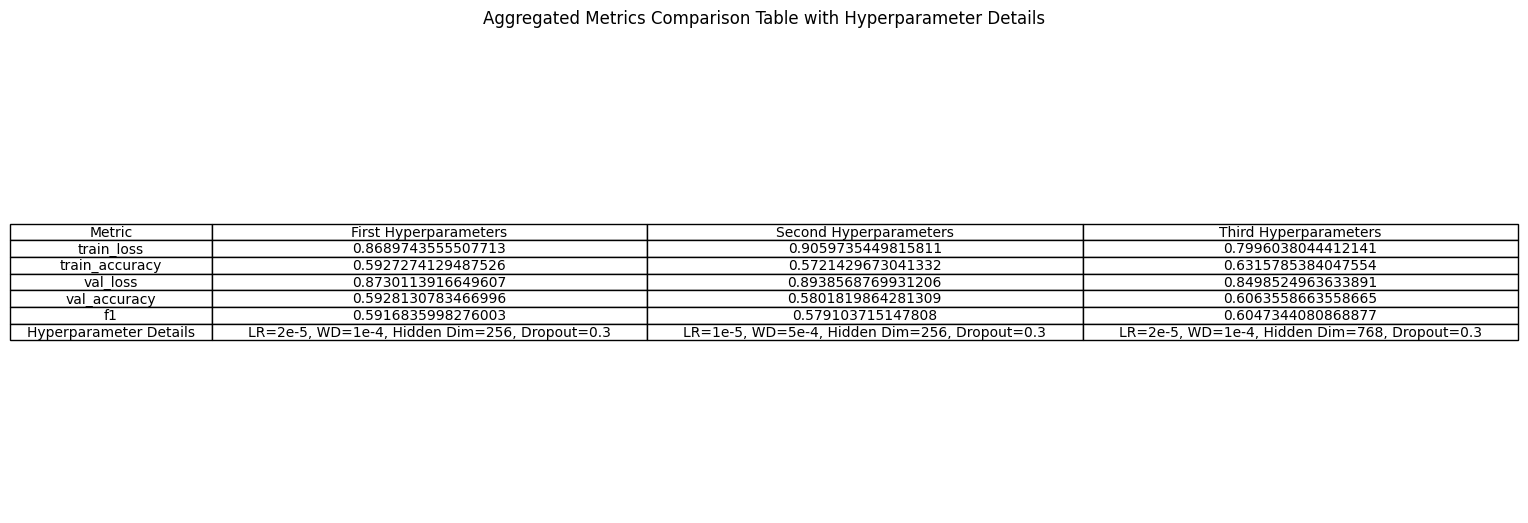

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results files
file_paths = [
    "/content/drive/My Drive/hybrid_model_first_hyperparams_results.csv",
    "/content/drive/My Drive/hybrid_model_results_new_params.csv",
    "/content/drive/My Drive/hybrid_model_new_hyperparams_results.csv",
]

results_data = [pd.read_csv(file) for file in file_paths]
labels = ["First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Merge data into a single DataFrame for comparison
comparison_df = pd.concat(
    [df.assign(Hyperparams=label) for df, label in zip(results_data, labels)],
    ignore_index=True,
)

# Aggregate Metrics for Each Hyperparameter Set
metrics = ["train_loss", "train_accuracy", "val_loss", "val_accuracy", "f1"]
aggregated_results = {
    "Metric": [],
    "First Hyperparameters": [],
    "Second Hyperparameters": [],
    "Third Hyperparameters": [],
}

for metric in metrics:
    aggregated_results["Metric"].append(metric)
    aggregated_results["First Hyperparameters"].append(results_data[0][metric].mean())
    aggregated_results["Second Hyperparameters"].append(results_data[1][metric].mean())
    aggregated_results["Third Hyperparameters"].append(results_data[2][metric].mean())

aggregated_df = pd.DataFrame(aggregated_results)

# Add Hyperparameter Details as a new row
hyperparam_row = pd.DataFrame({
    "Metric": ["Hyperparameter Details"],
    "First Hyperparameters": ["LR=2e-5, WD=1e-4, Hidden Dim=256, Dropout=0.3"],
    "Second Hyperparameters": ["LR=1e-5, WD=5e-4, Hidden Dim=256, Dropout=0.3"],
    "Third Hyperparameters": ["LR=2e-5, WD=1e-4, Hidden Dim=768, Dropout=0.3"],
})

aggregated_df = pd.concat([aggregated_df, hyperparam_row], ignore_index=True)

# Plain Aggregated Table with Hyperparameters
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis("off")
ax.axis("tight")

# Include hyperparameter details in the plain table
table_data = aggregated_df.values
column_labels = ["Metric", "First Hyperparameters", "Second Hyperparameters", "Third Hyperparameters"]

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(column_labels))))

ax.set_title("Aggregated Metrics Comparison Table with Hyperparameter Details", fontsize=12, pad=20)
plt.show()
